# **IS 360 Final Project - Logan Thomson**
## **Zillow Housing and US Census Data**

## Environment Setup
Importing python libraries for use in capturing, merging and plotting data

In [2]:
import urllib2
import json
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 30

## US Census Bureau API

Accessing the US Census data via their publicly available API.  Since the census is only taken every 10 years, I wanted to use more recent population data, so I used the American Community Survey (ACS) data, which is an ongoing, yearly survey.  However, since datasets (i.e. 2005-2009 and 2006-2010) cannot be overlapped per recommendation of the US Census Bureau, I used only the most recent four years (2011-2014).

In [3]:
html4 = urllib2.urlopen('http://api.census.gov/data/2014/acs5?get=NAME,B01001_001E&for=zip+code+tabulation+area:*&key=36fb45a72907a3a5e73f5b23c8cb331af1ace327')
census_14 = json.load(html4)

In [4]:
html3 = urllib2.urlopen('http://api.census.gov/data/2013/acs5?get=NAME,B01001_001E&for=zip+code+tabulation+area:*&key=36fb45a72907a3a5e73f5b23c8cb331af1ace327')
census_13 = json.load(html3)

In [5]:
html2 = urllib2.urlopen('http://api.census.gov/data/2012/acs5?get=NAME,B01001_001E&for=zip+code+tabulation+area:*&key=36fb45a72907a3a5e73f5b23c8cb331af1ace327')
census_12 = json.load(html2)

In [6]:
html1 = urllib2.urlopen('http://api.census.gov/data/2011/acs5?get=NAME,B01001_001E&for=zip+code+tabulation+area:*&key=36fb45a72907a3a5e73f5b23c8cb331af1ace327')
census_11 = json.load(html1)
census_11[0:5]

[[u'NAME', u'B01001_001E', u'zip code tabulation area'],
 [u'ZCTA5 01001', u'16775', u'01001'],
 [u'ZCTA5 01002', u'27684', u'01002'],
 [u'ZCTA5 01003', u'11516', u'01003'],
 [u'ZCTA5 01005', u'5045', u'01005']]

### Customize and Combine Data

As you can see above, the data provided from the API call that I used simply returns the zip code, and the corresponding population estimate. API calls can be made for different geographic levels (entire country, region, county, metro, zipcode, and the more granular "place" and "tracts"), and can also be customized to provide other demographic data (ethnic background, rent vs. own, etc.)

Below, I have added the year for each data set so that I could tell the data apart. Next, I combined each list into a list of lists so that I could loop over it and combine everything together.

In [7]:
for s in census_14:
    s.append('2014')
for s in census_13:
    s.append('2013')
for s in census_12:
    s.append('2012')
for s in census_11:
    s.append('2011')

In [8]:
census_11[0:5]

[[u'NAME', u'B01001_001E', u'zip code tabulation area', '2011'],
 [u'ZCTA5 01001', u'16775', u'01001', '2011'],
 [u'ZCTA5 01002', u'27684', u'01002', '2011'],
 [u'ZCTA5 01003', u'11516', u'01003', '2011'],
 [u'ZCTA5 01005', u'5045', u'01005', '2011']]

In [9]:
cen_list = [census_11, census_12, census_13, census_14]

Here I use a nested loop to loop over the list of Census lists, and create lists for each variable. The lists are then zipped together to make a pandas dataframe object, which I will then use to join with the Zillow data.

In [10]:
zip_code = []
pop = []
year = []
for i in cen_list:
    for y in i:
        zip_code.append(y[2].encode('utf8'))
        pop.append(y[1].encode('utf8'))
        year.append(y[3])

In [11]:
census_table = zip(year, zip_code, pop)
census_df = DataFrame(census_table, columns = ['Year', 'ZipCode', 'Population'])
census_df = census_df[census_df.ZipCode != 'zip code tabulation area']
census_df[0:5]

,Year,ZipCode,Population
1,2011,01001,16775
2,2011,01002,27684
3,2011,01003,11516
4,2011,01005,5045
5,2011,01007,14479


### Complete Census Data

Now that the census data is put together, I did a simple pivot operation (long to wide) so that each year was it's own column, and the zip code was the index of the dataframe.  Below is a sample of the first few rows of the data, and a sample of just one of the columns selected so we can see the data type.

In [12]:
census_df = census_df.pivot(index='ZipCode', columns='Year', values='Population')
census_df[1:6]

Year,2011,2012,2013,2014
ZipCode,,,,
00602,41930,41640,41302,40859
00603,54475,54540,53683,53162
00606,6386,6593,6591,6415
00610,29111,29141,28963,28805
00612,70541,69017,68055,66251


In [13]:
census_df['2011'][:2]

ZipCode
00601    18533
00602    41930
Name: 2011, dtype: object

## Zillow Housing Data

Zillow has many data sets available as downloadable .csv files.  Much like the Census Bureau information, different geographic levels of the data are available (State, Metro Area, County, Zip Code, etc.).  Since I wanted to break down the data to the smallest level possible, I used Zip Code data for Zillow's "Zillow Home Value Index" (or ZHVI), which has a clever way to look at median home values in an area without rates of differently-priced homes affecting the overall index.  You can read more about the methodology for how Zillow calculates the index here:  http://www.zillow.com/research/zhvi-methodology-6032/

First, I created an object called `zhvi` to store the data read from the .csv file.  Also, I changed the "RegionName" column (the zip code) variable to and object datatype, since I needed to merge my census data on this column and the datatypes need to match.

In [14]:
zhvi = pd.read_csv('Zip_Zhvi_Summary_AllHomes.csv', dtype={'RegionName': object})
zhvi.rename(columns={'RegionName':'ZipCode'}, inplace=True)

### Merging the Data

Here, instead of looping over rows of information, I let pandas do the heavy lifting. Below is a simple line of code I used to merge the dataframes together using the renamed "ZipCode" column and the index (also Zip Code) of the Census dataframe.

I then renamed the columns for the population estimate years, just to be a little more descriptive, and dropped any NaN columns.  These existed because the Zillow data did not have home values for sparsely populated zip codes, while the Census data had information for almost all Zip Codes (including Puerto Rico).

In [15]:
merge_df = zhvi.merge(census_df, how='outer', left_on='ZipCode', right_index=True)

In [16]:
merge_df = merge_df.rename(columns={'2011':'2011Pop', '2012':'2012Pop', '2013':'2013Pop', '2014':'2014Pop'}).dropna()

To add some calculated columns, I had to change the datatype for the population information (since everything is a string), and then added a column for population change from 2011 to 2014, and the % difference (+ or -) for the change.

In [17]:
merge_df['2014Pop'] = merge_df['2014Pop'].astype('int')
merge_df['2013Pop'] = merge_df['2013Pop'].astype('int')
merge_df['2012Pop'] = merge_df['2012Pop'].astype('int')
merge_df['2011Pop'] = merge_df['2011Pop'].astype('int')

In [18]:
merge_df['Pop. Change 11-14'] = merge_df['2014Pop'] - merge_df['2011Pop']
merge_df['% Pop. Change'] = (merge_df['Pop. Change 11-14'] / merge_df['2011Pop']) * 100

Here is our merged dataframe, sorted by "SizeRank", which is the population size of the individual zip code (not the metro area in total). Over to the right we can see the added columns.

In [19]:
merge_df[:6]

,Date,RegionID,ZipCode,State,Metro,County,City,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI,2011Pop,2012Pop,2013Pop,2014Pop,Pop. Change 11-14,% Pop. Change
0,2015-10-31,62080,11368,NY,New York,Queens,New York,0,363600,0.014792,0.021635,0.042431,0.065631,0.044881,2015-10,2015-Q4,363600,0.000000,2015-10,103401,104486,107962,110385,6984,6.754287
1,2015-10-31,93144,79936,TX,El Paso,El Paso,El Paso,1,111500,-0.002683,-0.006239,-0.010648,-0.008735,0.011249,2007-12,2007-Q4,131000,-0.148855,2006-07,114941,115538,114734,113451,-1490,-1.296317
2,2015-10-31,84630,60629,IL,Chicago,Cook,Chicago,2,139700,-0.004277,0.001434,0.038662,0.015279,-0.043305,2006-07,2006-Q3,232900,-0.400172,2002-06,112376,111893,113833,115013,2637,2.346586
3,2015-10-31,96193,90650,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles,Norwalk,3,397400,0.004804,0.017930,0.068854,0.064453,-0.012595,2006-08,2006-Q3,490100,-0.189145,2005-03,105348,105603,105940,106521,1173,1.113453
4,2015-10-31,62037,11226,NY,New York,Kings,New York,4,569300,0.018973,0.050951,0.150333,0.087604,0.050724,2015-10,2015-Q4,569300,0.000000,2015-10,99422,99285,98325,98299,-1123,-1.129529
5,2015-10-31,62093,11385,NY,New York,Queens,New York,5,528300,0.009169,0.028621,0.085474,0.043398,0.017719,2015-10,2015-Q4,528300,0.000000,2015-10,99295,99508,99379,100132,837,0.842943


### Merged Data Summary

In [20]:
merge_df.describe()

,RegionID,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakZHVI,PctFallFromPeak,2011Pop,2012Pop,2013Pop,2014Pop,Pop. Change 11-14,% Pop. Change
count,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,11865.000000,1.186500e+04
mean,79811.772861,6337.822756,257271.352718,0.003218,0.011619,0.043811,0.024192,-0.002865,295102.233460,-0.131228,18795.647956,18975.799157,19147.045849,19333.060683,537.412727,inf
std,30849.006641,3754.126757,247699.077923,0.007323,0.019262,0.055172,0.033490,0.021131,259001.408268,0.121513,16075.536406,16257.781609,16427.326954,16634.553914,1264.524691,NaN
min,58196.000000,0.000000,28900.000000,-0.055609,-0.114496,-0.227796,-0.097345,-0.081170,37700.000000,-0.586010,0.000000,16.000000,0.000000,15.000000,-7008.000000,-6.130137e+01
25%,65772.000000,3074.000000,128800.000000,-0.000234,0.001257,0.009411,0.001578,-0.017704,145000.000000,-0.215676,5487.000000,5519.000000,5550.000000,5577.000000,-97.000000,-1.049633e+00
50%,74784.000000,6234.000000,186000.000000,0.003279,0.011364,0.040193,0.018412,-0.002974,222300.000000,-0.107080,14593.000000,14740.000000,14882.000000,15099.000000,214.000000,1.895252e+00
75%,90315.000000,9570.000000,296400.000000,0.007020,0.022056,0.073500,0.042700,0.011595,358000.000000,-0.016013,28071.000000,28366.000000,28561.000000,28842.000000,874.000000,5.531537e+00
max,417461.000000,13054.000000,5951300.000000,0.059172,0.138577,0.408602,0.189408,0.119510,5951300.000000,0.000000,114941.000000,115538.000000,114734.000000,115013.000000,23309.000000,inf


#### Zip Codes with greatest % increase in population

Let's just sort the information to see the highest percent population change, this will also allow us to see any outliers.  Naturally, the smaller population zipcodes have the highest estimated change, as any slight amounts of growth will result in huge increases in percentage points.

In [21]:
top_pop_change_pct = merge_df
top_pop_change_pct = top_pop_change_pct.sort(['% Pop. Change'], ascending=False)
top_pop_change_pct[:6]

,Date,RegionID,ZipCode,State,Metro,County,City,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI,2011Pop,2012Pop,2013Pop,2014Pop,Pop. Change 11-14,% Pop. Change
12824,2015-10-31,72865,33855,FL,Lakeland,Polk,Lake Wales,12824,128700,-0.006944,-0.013037,0.048900,0.014097,-0.025889,2007-07,2007-Q3,184000,-0.300543,2004-12,0,16,16,15,15,inf
12512,2015-10-31,72418,33109,FL,Miami-Fort Lauderdale,Miami-Dade,Fisher Island,12512,3163200,0.009833,0.013099,0.099746,0.079151,0.031075,2015-10,2015-Q4,3163200,0.000000,2015-10,150,482,508,523,373,248.666667
12776,2015-10-31,98404,95728,CA,Truckee,Nevada,Truckee,12776,513600,0.005875,0.046455,0.146173,0.047832,-0.008647,2005-06,2005-Q2,568900,-0.097205,2005-03,227,352,495,495,268,118.061674
11833,2015-10-31,93469,80547,CO,Fort Collins,Larimer,Fort Collins,11833,417700,0.006506,0.010646,0.111495,0.050823,0.032114,2015-10,2015-Q4,417700,0.000000,2015-10,572,746,880,1223,651,113.811189
12060,2015-10-31,95246,87010,NM,Santa Fe,Santa Fe,Cerrillos,12060,328200,0.004591,0.003056,0.007676,-0.011021,0.054802,2009-07,2009-Q3,494300,-0.336031,2008-10,616,975,1092,1281,665,107.954545
12282,2015-10-31,70763,29915,SC,Hilton Head Island,Beaufort,Bluffton,12282,456300,-0.034694,-0.114496,-0.097329,-0.053630,-0.050049,2006-06,2006-Q2,803800,-0.432321,2000-06,322,599,603,648,326,101.242236


#### Greatest estimated increase in population

Here, we look at the zip codes with the greatest increase in estimated population count.  Not surprisingly, most of the zip codes are in Texas, which has been experiencing explosive population growth in the last decade.

In [22]:
top_pop_change = merge_df
top_pop_change = top_pop_change_pct.sort(['Pop. Change 11-14'], ascending=False)
top_pop_change[:10]

,Date,RegionID,ZipCode,State,Metro,County,City,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI,2011Pop,2012Pop,2013Pop,2014Pop,Pop. Change 11-14,% Pop. Change
1340,2015-10-31,91982,77494,TX,Houston,Fort Bend,Cinco Ranch,1340,314000,0.006410,0.005122,0.048764,0.042996,0.047351,2015-05,2015-Q2,314800,-0.002541,2015-04,55808,64378,71613,79117,23309,41.766413
979,2015-10-31,91926,77433,TX,Houston,Harris,Cypress,979,228100,-0.004799,0.000439,0.080019,0.049089,0.034048,2015-08,2015-Q3,229300,-0.005233,2015-08,44962,51200,55563,60324,15362,34.166630
2084,2015-10-31,71831,32162,FL,The Villages,Sumter,The Villages,2084,244100,0.000000,-0.003267,-0.015329,0.038075,0.015791,2006-12,2006-Q4,253300,-0.036321,2006-08,36887,43460,49812,52224,15337,41.578334
932,2015-10-31,90637,75034,TX,Dallas-Fort Worth,Collin,Frisco,932,384300,0.003656,0.019904,0.157182,0.065908,0.030309,2015-10,2015-Q4,384300,0.000000,2015-10,66738,71123,75490,80917,14179,21.245767
74,2015-10-31,91940,77449,TX,Houston,Harris,Cypress,74,149800,0.004695,0.023923,0.117077,0.051027,0.018264,2015-10,2015-Q4,149800,0.000000,2015-10,86302,90599,95615,99450,13148,15.234873
370,2015-10-31,93146,79938,TX,El Paso,El Paso,El Paso,370,128500,-0.002329,-0.004648,0.016614,-0.009233,0.012045,2007-11,2007-Q4,135400,-0.050960,2006-11,51367,54984,59252,63471,12104,23.563767
1492,2015-10-31,399654,85140,AZ,Phoenix,Pinal,Queen Creek,1492,172600,0.010539,0.043531,0.043531,0.094681,-0.028471,2006-03,2006-Q1,245900,-0.298089,2005-03,27570,32540,37063,39508,11938,43.300689
79,2015-10-31,90668,75070,TX,Dallas-Fort Worth,Collin,McKinney,79,270500,0.004829,0.021526,0.176599,0.084031,0.036613,2015-10,2015-Q4,270500,0.000000,2015-10,70901,74753,78837,82195,11294,15.929253
1071,2015-10-31,92045,77584,TX,Houston,Brazoria,Pearland,1071,217100,0.005558,0.021167,0.102590,0.038538,0.017178,2015-10,2015-Q4,217100,0.000000,2015-10,65756,71277,74761,76495,10739,16.331590
29,2015-10-31,62025,11214,NY,New York,Kings,New York,29,544800,0.013204,0.041085,0.055609,0.045084,0.021039,2015-10,2015-Q4,544800,0.000000,2015-10,78326,81428,83156,88297,9971,12.730128


#### % Change in population, bottom 10

In [23]:
top_pop_change[-10::]

,Date,RegionID,ZipCode,State,Metro,County,City,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI,2011Pop,2012Pop,2013Pop,2014Pop,Pop. Change 11-14,% Pop. Change
2621,2015-10-31,75213,39209,MS,Jackson,Hinds,Jackson,2621,45400,0.008889,0.002208,-0.054167,-0.025277,0.010740,2009-08,2009-Q3,65700,-0.308980,2008-08,30835,30391,28998,27188,-3647,-11.827469
2965,2015-10-31,73964,36605,AL,Mobile,Mobile,Mobile,2965,52300,-0.016917,-0.040367,-0.043876,-0.024151,-0.016870,2008-08,2008-Q3,70500,-0.258156,2001-02,31649,29886,29613,27860,-3789,-11.971942
1138,2015-10-31,96602,92037,CA,San Diego,San Diego,San Diego,1138,1360200,0.005544,0.010850,0.063238,0.046441,0.003936,2015-10,2015-Q4,1360200,0.000000,2015-10,43149,41746,40114,39241,-3908,-9.056989
1855,2015-10-31,58649,02135,MA,Boston,Suffolk,Boston,1855,344300,0.007314,0.022876,0.099298,0.060314,0.019190,2015-10,2015-Q4,344300,0.000000,2015-10,40493,38839,36932,36486,-4007,-9.895538
1259,2015-10-31,77020,44120,OH,Cleveland,Cuyahoga,Cleveland,1259,73800,-0.014686,-0.025099,-0.009396,-0.004544,-0.034092,2005-07,2005-Q3,104700,-0.295129,1998-09,40181,37763,36313,35768,-4413,-10.982803
1354,2015-10-31,65803,19136,PA,Philadelphia,Philadelphia,Philadelphia,1354,118600,0.000844,-0.007531,-0.005868,-0.024557,-0.015534,2006-07,2006-Q3,147700,-0.197021,2005-04,39680,39587,36865,34873,-4807,-12.114415
2934,2015-10-31,72372,33034,FL,Miami-Fort Lauderdale,Miami-Dade,Florida City,2934,91400,0.008830,0.028121,0.031603,0.070220,-0.057929,2007-03,2007-Q1,205300,-0.554798,2003-10,29448,27587,26083,24473,-4975,-16.894186
82,2015-10-31,84622,60620,IL,Chicago,Cook,Chicago,82,117800,0.006838,0.030621,-0.001695,-0.017391,-0.023091,2007-12,2007-Q4,165300,-0.287356,2003-07,77452,74245,73253,71907,-5545,-7.159273
40,2015-10-31,84619,60617,IL,Chicago,Cook,Chicago,40,104300,0.005786,0.010659,-0.022493,-0.038466,-0.035168,2007-03,2007-Q1,162600,-0.358549,2001-12,88799,84882,83435,82685,-6114,-6.885213
70,2015-10-31,84629,60628,IL,Chicago,Cook,Chicago,70,89900,-0.017486,-0.045648,-0.087310,-0.040424,-0.036286,2008-02,2008-Q1,143000,-0.371329,2001-05,76929,74001,71710,69921,-7008,-9.109699


#### Top Zip Codes by 10-Year Change in Zillow Home Value Index

Here are the zip codes sorted by the % change in teh Zillow index over the last 10 years.  Looks like buying a home in New York City or Texas in the last 10 years was a pretty good investment.

In [24]:
top_zhvi = merge_df
top_zhvi = top_zhvi.sort(['10Year'], ascending=False)

In [25]:
top_zhvi[0:10]

,Date,RegionID,ZipCode,State,Metro,County,City,SizeRank,Zhvi,MoM,QoQ,YoY,5Year,10Year,PeakMonth,PeakQuarter,PeakZHVI,PctFallFromPeak,LastTimeAtCurrZHVI,2011Pop,2012Pop,2013Pop,2014Pop,Pop. Change 11-14,% Pop. Change
390,2015-10-31,62027,11216,NY,New York,Kings,New York,390,830900,0.017886,0.047529,0.130630,0.141828,0.119510,2015-10,2015-Q4,830900,0.000000,2015-10,53065,53662,53783,54440,1375,2.591162
1485,2015-10-31,62033,11222,NY,New York,New York,New York,1485,892100,0.015481,0.047804,0.093126,0.127402,0.107173,2015-10,2015-Q4,892100,0.000000,2015-10,33482,33718,34186,34580,1098,3.279374
9398,2015-10-31,77855,45846,OH,Celina,Mercer,Fort Recovery,9398,279700,0.021176,0.053484,0.313146,0.189408,0.093233,2015-10,2015-Q4,279700,0.000000,2015-10,4479,4295,4236,4211,-268,-5.983478
734,2015-10-31,62016,11205,NY,New York,Kings,New York,734,737300,0.018792,0.066696,0.132913,0.113045,0.092031,2015-10,2015-Q4,737300,0.000000,2015-10,38997,40125,43002,43320,4323,11.085468
7992,2015-10-31,63934,15203,PA,Pittsburgh,Allegheny,Pittsburgh,7992,154000,-0.005168,0.002604,0.036339,0.097991,0.085658,2015-09,2015-Q3,154800,-0.005168,2015-08,10529,9884,10134,9992,-537,-5.100199
11110,2015-10-31,77866,45860,OH,Celina,Mercer,Saint Henry,11110,320800,0.038524,0.099760,0.251170,0.172771,0.082721,2015-10,2015-Q4,320800,0.000000,2015-10,2150,2197,2094,2135,-15,-0.697674
8488,2015-10-31,93036,79706,TX,Midland,Midland,Midland,8488,221100,-0.008520,-0.020381,-0.000452,0.056593,0.082037,2015-04,2015-Q2,228700,-0.033231,2014-10,18106,19181,20577,21187,3081,17.016459
1448,2015-10-31,62041,11231,NY,New York,Kings,New York,1448,1084300,0.010249,0.035131,0.179998,0.124481,0.080851,2015-10,2015-Q4,1084300,0.000000,2015-10,35109,34393,34137,34605,-504,-1.435529
4705,2015-10-31,91667,77018,TX,Houston,Harris,Houston,4705,346500,0.000867,0.010499,0.011974,0.103041,0.080741,2015-01,2015-Q1,348600,-0.006024,2014-12,27253,27627,26794,27020,-233,-0.854952
1244,2015-10-31,91704,77055,TX,Houston,Harris,Houston,1244,343400,0.010594,0.044404,0.161705,0.081963,0.079905,2015-10,2015-Q4,343400,0.000000,2015-10,43977,43603,44281,44249,272,0.618505


## Plotting Data for Analysis

Now that we've made some observations on the data in table form, we will plot the data to see if we can gain any other insights.

My hypothesis is that more people are moving to cities, and housing values and populations should be increasing overall more in zip codes located in larger metro areas. There are many factors behind this, so I will compare two  metro areas of similar size with different population and housing stories for the last ten years.

### Plotting All Data

Below are all zip codes containing data, only looking at the 5-year change in the home value index, and the short-term change in population (by %). The lighter colored hex bins represent the rank in size of zip code; note that most of the larger ranked areas are to the right, showing the highest increases in median home values.

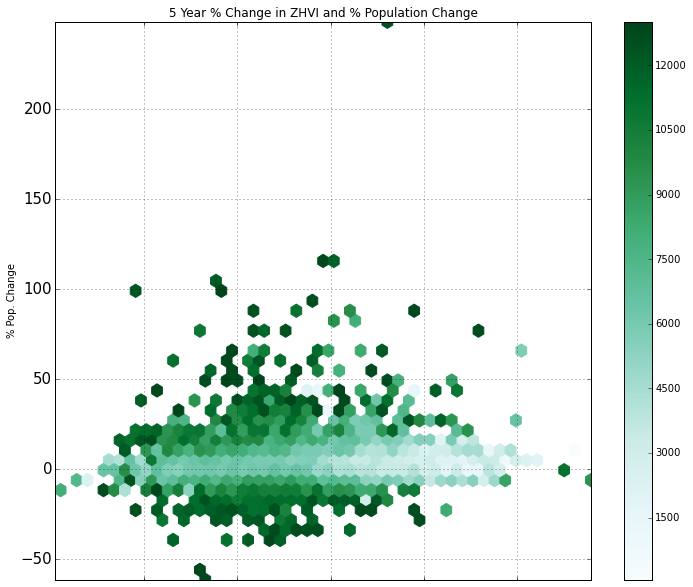

In [26]:
a = merge_df.plot(kind='hexbin', x='5Year', y='% Pop. Change', C='SizeRank', 
              title='5 Year % Change in ZHVI and % Population Change', 
              fontsize=15, grid=True, gridsize=50, figsize=(12, 10))

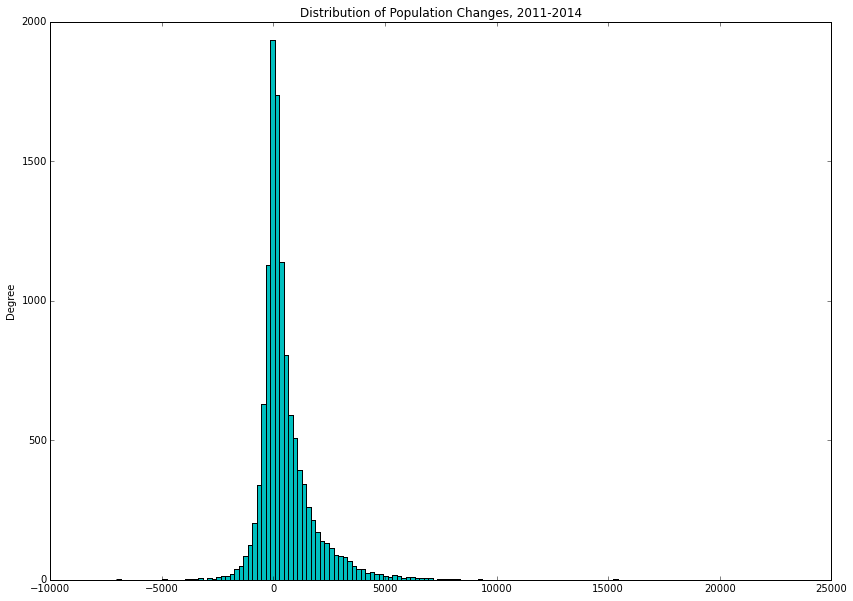

In [27]:
merge_df['Pop. Change 11-14'].plot(kind='hist', bins=150, color='c', 
                                   title='Distribution of Population Changes, 2011-2014', figsize=(14, 10))

### Top 1000 largest zip codes by population

Since we have a lot of zip codes in our dataset, let's look at the 1000 largest to see if there is any correlation between short-term change in median home value for higher population zip codes.

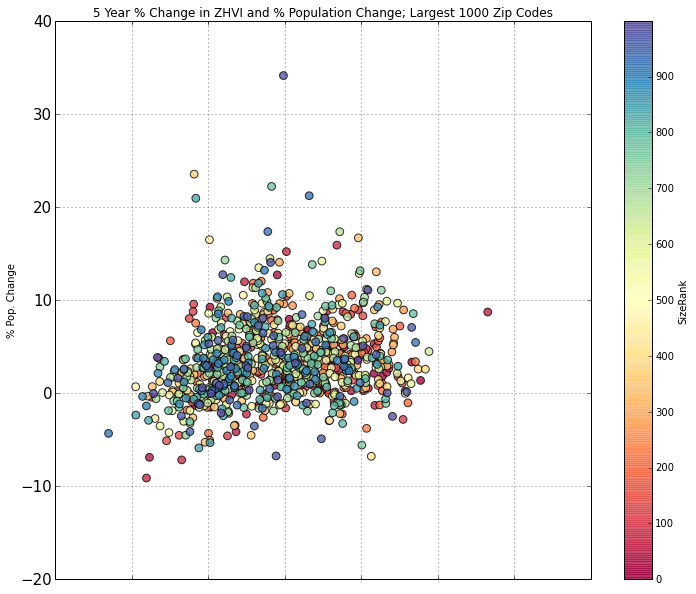

In [28]:
top_1000 = merge_df[merge_df.SizeRank < 1000]
top_1000.plot(kind='scatter', x='5Year', y='% Pop. Change', c='SizeRank',
              title='5 Year % Change in ZHVI and % Population Change; Largest 1000 Zip Codes', 
              fontsize=15, colormap='Spectral', s=60, grid=True, alpha=.8, figsize=(12, 10))

### Bottom 1000+ smallest zip codes by population

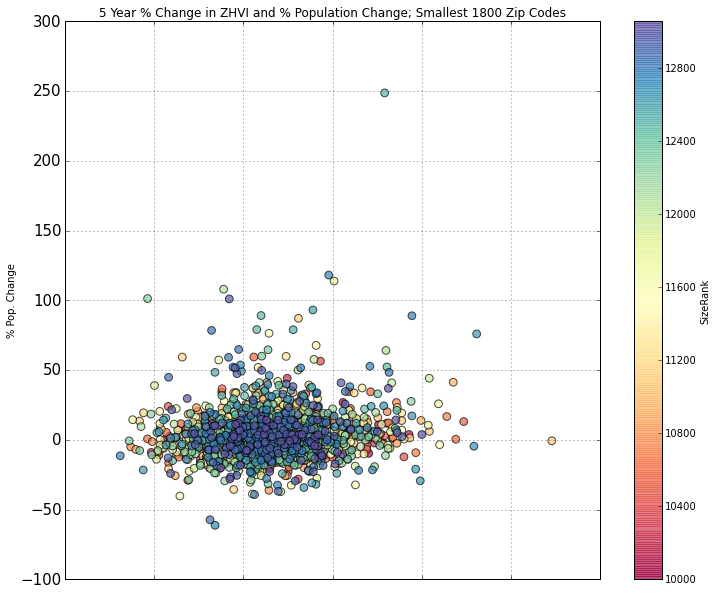

In [29]:
under_1000 = merge_df[merge_df.SizeRank > 10000]
under_1000.plot(kind='scatter', x='5Year', y='% Pop. Change', c='SizeRank',
                title='5 Year % Change in ZHVI and % Population Change; Smallest 1800 Zip Codes',
                fontsize=15, s=60, grid=True, colormap='Spectral', alpha=.7, figsize=(12, 10))

### New York Metro Area

Since we've looked at the top and bottom of our data, let's narrow it down to just a singular Metro area. The New York Metro Area includes the city and surrounding counties in Long Island, New Jersey, etc.

The information appears to be centrally distributed, with changes in median home values skewed to the right (increasing).  Note the difference in median home values for the NY area zip codes!

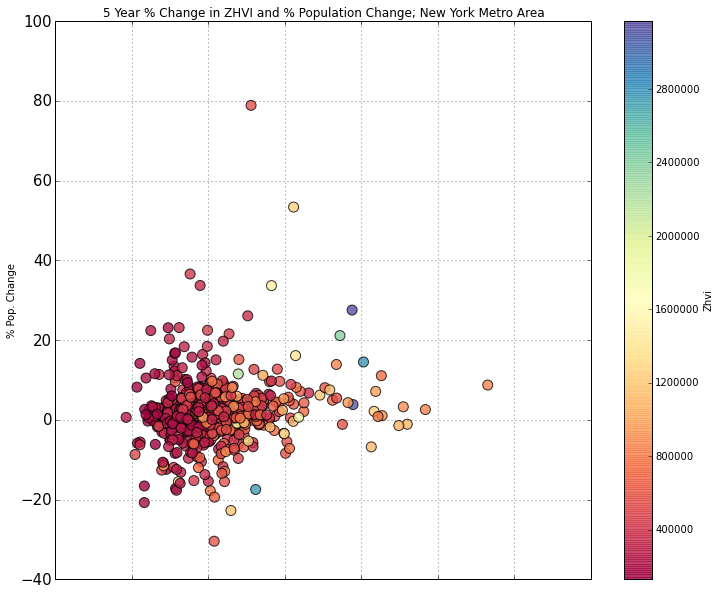

In [30]:
NY_Metro = merge_df[merge_df.Metro == 'New York']
NY_Metro.plot(kind='scatter', x='5Year', y='% Pop. Change', s=100,
              title='5 Year % Change in ZHVI and % Population Change; New York Metro Area',
              fontsize=15, c='Zhvi', colormap='Spectral', grid=True, alpha=.8, figsize=(12, 10))

### **Comparing two different metro areas**

Below are two metro areas in the U.S. that are similar in size (around 750,000 people), yet have different stories when it comes to population growth. 

#### Detroit

Below we can see that Detroit has experienced a relative increase in median home values in the last ten years, with most zip codes experiencing < 10% increases in population in the last 4 years. Note that most of the zip codes with higher percentage increases in the last 10 years already have higher median home values.

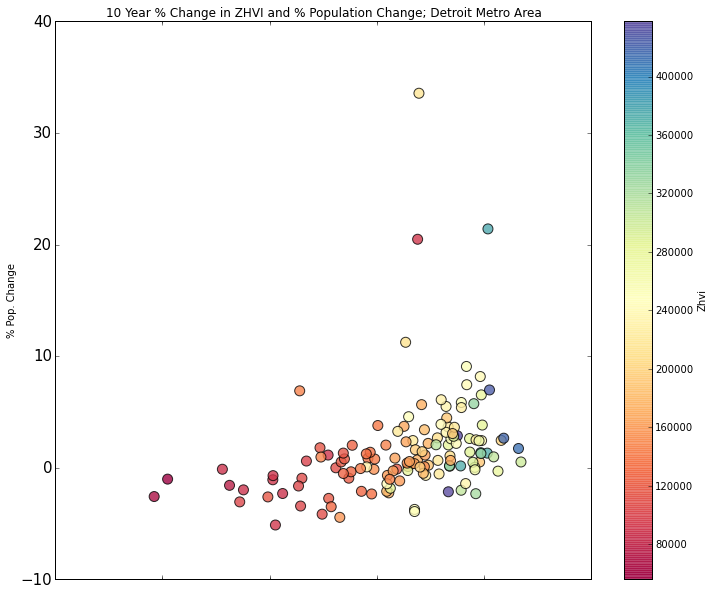

In [31]:
Detroit = merge_df[merge_df.Metro == 'Detroit']
Detroit.plot(kind='scatter', x='10Year', y='% Pop. Change', c='Zhvi',
             title='10 Year % Change in ZHVI and % Population Change; Detroit Metro Area',
             fontsize=15, colormap='Spectral', s=100, alpha=.8, figsize=(12, 10))

#### **Charlotte, NC**

Charlotte, NC has experienced explosive growth in the last ten years, and has a much different story than Detroit. We can see from the plot below that the short-term % increase in population is much more drastic for some zip codes than Detroit (or the US as a whole), and also has inceases in median home values to go along with it.  Ineterestingly, the Charlotte metro area also has some zip codes with some drastic short-term population decreases.  This may be because of re-zoning, or migration of the city population from one area to another.

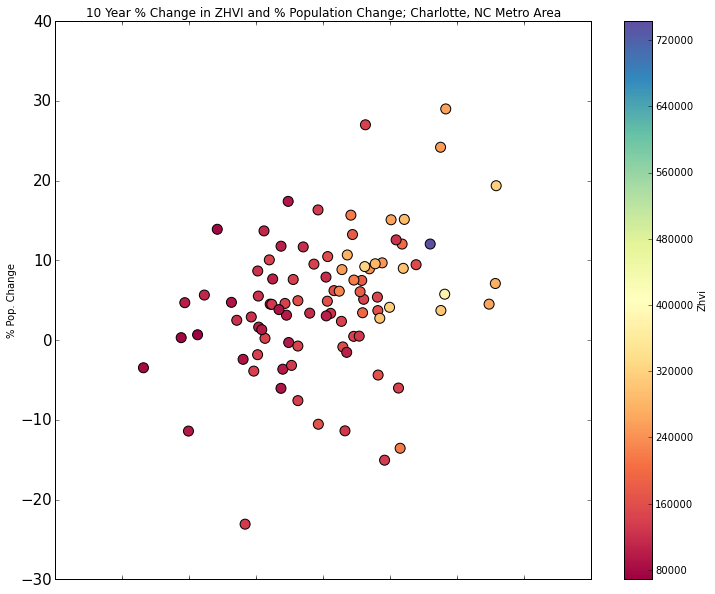

In [32]:
Charlotte = merge_df[merge_df.Metro == 'Charlotte']
Charlotte.plot(kind='scatter', x='10Year', y='% Pop. Change', 
               title='10 Year % Change in ZHVI and % Population Change; Charlotte, NC Metro Area',               
               fontsize=15, c='Zhvi', colormap='Spectral', s=100, figsize=(12, 10))

### Conclusion

Though some pretty powerful data was made available to us, considering all of the variables that are possible factors to population growth, the analysis was fairly limited.  There does appear to be some correlation between population size of an area, and continued population growth and increasing median home values.  However, looking at two different cities of similar sizes can highlight much different stories, and other economic, demographic, and geographic factors play a role in the increase (or decrease) in population and home values.

Overall, it would be better to use more historical data for population, rather than just a short-term view.  Also, using some of the other variables available (age ranges, rent vs. owning, household size) it would be valuable to break down the data and look at how the data varies among these sub-groups of data.